# QLoRA Fine-Tuning for CLIP

This notebook fine-tunes CLIP using **QLoRA** (Quantized Low-Rank Adaptation) on the food recipe dataset.

**Hypothesis H2:** QLoRA achieves comparable performance to LoRA while using significantly less memory, enabling fine-tuning on resource-constrained hardware.

**This notebook (M2 QLoRA):**
- Loads pre-trained CLIP model with **4-bit NF4 quantization** using bitsandbytes
- Applies LoRA adapters to trainable modules (same config as M1)
- Fine-tunes on training set using CLIP contrastive loss
- Evaluates on test set with **same protocol as baseline and LoRA**
- Compares memory usage and performance with M0 (baseline) and M1 (LoRA)

**Key Differences from LoRA:**
- Base model weights are quantized to 4-bit NF4 using bitsandbytes
- ~4x memory savings compared to FP32 model
- **Requires CUDA GPU** (bitsandbytes does not support CPU or MPS)

**Inputs:**
- `fine-tuning-zone/datasets/train_pairs_augmented_with_negatives.csv` (for training, filtered to label==1)
- `fine-tuning-zone/datasets/test_pairs_positive.csv` (for evaluation)
- `fine-tuning-zone/images/` and `fine-tuning-zone/augmented_images/` (images)

**Outputs:**
- `fine-tuning-zone/experiments/qlora/run_{run_id}/` — Complete run directory with:
  - `config.yaml` — Training configuration
  - `adapters/` — LoRA adapter weights
  - `training_logs.json` — Loss and timing logs
  - `results_qlora.json` — Evaluation metrics
  - `examples_top5.json` — Qualitative examples


## 1. Setup and Configuration


In [19]:
import os
import io
import json
import time
import math
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from tqdm import tqdm
import yaml

# CLIP and LoRA imports
TRANSFORMERS_AVAILABLE = False
PEFT_AVAILABLE = False
BNB_AVAILABLE = False

try:
    from transformers import CLIPModel, CLIPProcessor, BitsAndBytesConfig
    TRANSFORMERS_AVAILABLE = True
    print("✓ transformers imported successfully")
except ImportError as e:
    print(f"✗ Failed to import transformers: {e}")

try:
    from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
    PEFT_AVAILABLE = True
    print("✓ peft imported successfully")
except ImportError as e:
    print(f"✗ Failed to import peft: {e}")
    TaskType = None

try:
    import bitsandbytes as bnb
    BNB_AVAILABLE = True
    print("✓ bitsandbytes imported successfully")
except ImportError as e:
    print(f"⚠ bitsandbytes not available: {e}")
    print("  QLoRA requires bitsandbytes. Install with: pip install bitsandbytes")

# Load environment variables
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

ENV_PATHS = [
    PROJECT_ROOT / "notebooks" / ".env",
    PROJECT_ROOT / "app" / ".env",
    PROJECT_ROOT / ".env",
]

env_loaded = False
for env_path in ENV_PATHS:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    print("⚠ No .env file found, trying default load_dotenv()...")
    load_dotenv()

# Load experiment configuration
CONFIG_PATH = NOTEBOOK_DIR / "experiment_config.yaml"
if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"Config file not found: {CONFIG_PATH}")

with open(CONFIG_PATH, 'r') as f:
    CONFIG = yaml.safe_load(f)

# MinIO Configuration (from environment)
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")

# MinIO configuration (from config)
FINE_TUNING_BUCKET = CONFIG["minio"]["bucket"]
DATASETS_PREFIX = CONFIG["minio"]["prefixes"]["datasets"]
IMAGES_PREFIX = CONFIG["minio"]["prefixes"]["images"]
EXPERIMENTS_PREFIX = CONFIG["minio"]["prefixes"]["experiments"]

# Model configuration
MODEL_NAME = CONFIG["model"]["name"]

# Device selection - QLoRA requires CUDA
def pick_device():
    """Pick device for QLoRA. Requires CUDA for bitsandbytes quantization."""
    if torch.cuda.is_available():
        try:
            _ = torch.randn(1, device="cuda")
            print("✓ CUDA available - QLoRA with 4-bit quantization enabled")
            return "cuda"
        except Exception as e:
            print(f"⚠ CUDA visible but not usable: {e}")
    
    # QLoRA requires CUDA - show clear error message
    print("=" * 60)
    print("⚠ CUDA NOT AVAILABLE - QLoRA REQUIRES CUDA")
    print("=" * 60)
    print("  QLoRA uses bitsandbytes for 4-bit quantization, which requires CUDA.")
    print("  Options:")
    print("    1. Run this notebook on a CUDA-capable GPU")
    print("    2. Use 02_lora_finetune_clip.ipynb for LoRA without quantization")
    print("=" * 60)
    return "cpu"  # Will fail later with clear error

DEVICE = pick_device()
BATCH_SIZE = CONFIG["model"]["batch_size"]

# QLoRA configuration (from config)
QLORA_CONFIG = CONFIG.get("qlora", {})
LOAD_IN_4BIT = QLORA_CONFIG.get("load_in_4bit", True)
BNB_4BIT_QUANT_TYPE = QLORA_CONFIG.get("bnb_4bit_quant_type", "nf4")
BNB_4BIT_COMPUTE_DTYPE = QLORA_CONFIG.get("bnb_4bit_compute_dtype", "float16")
BNB_4BIT_USE_DOUBLE_QUANT = QLORA_CONFIG.get("bnb_4bit_use_double_quant", True)

# LoRA configuration (from qlora section, same as lora for fair comparison)
LORA_CONFIG = {
    "r": int(QLORA_CONFIG.get("r", 8)),
    "lora_alpha": int(QLORA_CONFIG.get("lora_alpha", 16)),
    "lora_dropout": float(QLORA_CONFIG.get("lora_dropout", 0.05)),
    "bias": QLORA_CONFIG.get("bias", "none"),
    "task_type": TaskType.FEATURE_EXTRACTION if TaskType else None,
    "target_modules": QLORA_CONFIG.get("target_modules", ["q_proj", "k_proj", "v_proj", "out_proj"]),
}

# Training configuration
learning_rate = CONFIG["training"]["learning_rate"]
if isinstance(learning_rate, str):
    learning_rate = float(learning_rate)

# QLoRA training adjustments:
# - Lower LR to prevent gradient instability with quantized weights
# - Shorter warmup since total steps is ~138
QLORA_LR = 2e-5
QLORA_WARMUP = 10

TRAINING_CONFIG = {
    "learning_rate": QLORA_LR,
    "num_epochs": int(CONFIG["training"]["num_epochs"]),
    "batch_size": int(CONFIG["training"]["batch_size"]),
    "gradient_accumulation_steps": int(CONFIG["training"]["gradient_accumulation_steps"]),
    "warmup_steps": QLORA_WARMUP,
    "logging_steps": int(CONFIG["training"]["logging_steps"]),
    "save_steps": int(CONFIG["training"]["save_steps"]),
}

print(f"\nQLoRA training config:")
print(f"  Learning rate: {QLORA_LR} (lowered from {learning_rate})")
print(f"  Warmup steps: {QLORA_WARMUP}")

# QLoRA training configuration
LORA_SCOPE = QLORA_CONFIG.get("scope", "both")
TRAIN_ONLY_LORA = QLORA_CONFIG.get("train_only_lora", True)
TRAIN_LOGIT_SCALE = QLORA_CONFIG.get("train_logit_scale", True)

# Logit scale clamping constants
LOGIT_SCALE_MIN = math.log(1/100)
LOGIT_SCALE_MAX = math.log(100)

# Evaluation configuration
K_VALUES = CONFIG["evaluation"]["k_values"]
COMPUTE_MRR = CONFIG["evaluation"]["compute_mrr"]
COMPUTE_MEDIAN_RANK = CONFIG["evaluation"].get("compute_median_rank", True)

# Experiment configuration - force method to "qlora" for this notebook
METHOD = "qlora"
RESULTS_DIR_BASE = CONFIG["experiment"]["results_dir"]

# Run configuration
RUN_ID = f"{METHOD}_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}"
RUN_DIR = f"{RESULTS_DIR_BASE}/{METHOD}/run_{RUN_ID}"

# Input/Output paths
TRAIN_AUGMENTED_KEY = CONFIG["dataset"]["train_manifest_key"]
TEST_MANIFEST_KEY = CONFIG["dataset"]["test_manifest_key"]

CONFIG_KEY = f"{RUN_DIR}/config.yaml"
ADAPTERS_DIR = f"{RUN_DIR}/adapters"
LOGS_KEY = f"{RUN_DIR}/training_logs.json"
RESULTS_KEY = f"{RUN_DIR}/results_{METHOD}.json"
EXAMPLES_KEY = f"{RUN_DIR}/examples_top5.json"

# Update config to include dataset info
TRAINING_CONFIG["train_dataset"] = TRAIN_AUGMENTED_KEY
TRAINING_CONFIG["test_dataset"] = TEST_MANIFEST_KEY
TRAINING_CONFIG["filter_applied"] = "label == 1 (positive pairs only)"

print(f"\nConfiguration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {DEVICE}")
print(f"  Method: QLoRA (4-bit quantized)")
print(f"  Quantization: {BNB_4BIT_QUANT_TYPE}, double_quant={BNB_4BIT_USE_DOUBLE_QUANT}")
print(f"  LoRA r: {LORA_CONFIG['r']}, alpha: {LORA_CONFIG['lora_alpha']}")
print(f"  Training: {TRAINING_CONFIG['num_epochs']} epochs, LR={TRAINING_CONFIG['learning_rate']}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']} (effective: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']})")
print(f"  Run ID: {RUN_ID}")


✓ transformers imported successfully
✓ peft imported successfully
✓ bitsandbytes imported successfully
✓ Loaded .env from: /home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/notebooks/.env
✓ CUDA available - QLoRA with 4-bit quantization enabled

QLoRA training config:
  Learning rate: 2e-05 (lowered from 0.0001)
  Warmup steps: 10

Configuration:
  Model: openai/clip-vit-base-patch32
  Device: cuda
  Method: QLoRA (4-bit quantized)
  Quantization: nf4, double_quant=True
  LoRA r: 8, alpha: 16
  Training: 3 epochs, LR=2e-05
  Batch size: 2 (effective: 32)
  Run ID: qlora_20260108_201025


## 2. Initialize MinIO Client


In [20]:
# Initialize S3/MinIO client
session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

def ensure_bucket_exists(bucket: str) -> bool:
    """Create bucket if it doesn't exist."""
    try:
        s3.head_bucket(Bucket=bucket)
        return True
    except ClientError as e:
        error_code = e.response.get("Error", {}).get("Code", "")
        if error_code in ("404", "NoSuchBucket"):
            try:
                s3.create_bucket(Bucket=bucket)
                print(f"✓ Created bucket '{bucket}'")
                return True
            except ClientError as create_error:
                print(f"✗ Failed to create bucket '{bucket}': {create_error}")
                return False
        return False

# Verify buckets
print("Checking buckets...")
ensure_bucket_exists(FINE_TUNING_BUCKET)
print("✓ Buckets ready")


Checking buckets...
✓ Buckets ready


## 3. Load Training and Test Datasets


In [21]:
# Load training dataset
print("Loading training dataset...")
train_obj = s3.get_object(Bucket=FINE_TUNING_BUCKET, Key=TRAIN_AUGMENTED_KEY)
train_full_df = pd.read_csv(io.BytesIO(train_obj["Body"].read()))

# Filter to positive pairs only (label == 1)
if "label" in train_full_df.columns:
    train_df = train_full_df[train_full_df["label"] == 1].copy()
    print(f"✓ Loaded {len(train_df)} positive pairs")
    print(f"  Removed {len(train_full_df) - len(train_df)} negative pairs")
else:
    train_df = train_full_df.copy()
    print(f"\n✓ No label column found, using all {len(train_df)} pairs as positive")

# Load test dataset
print("\nLoading test dataset...")
test_obj = s3.get_object(Bucket=FINE_TUNING_BUCKET, Key=TEST_MANIFEST_KEY)
test_df = pd.read_csv(io.BytesIO(test_obj["Body"].read()))
print(f"✓ Loaded {len(test_df)} test pairs")
print(f"  Recipes: {test_df['recipe_id'].nunique()}")
print(f"  Images: {test_df['image_key'].nunique()}")
print(f"  Captions: {test_df['caption'].nunique()}")


Loading training dataset...


✓ Loaded 1460 positive pairs
  Removed 365 negative pairs

Loading test dataset...
✓ Loaded 97 test pairs
  Recipes: 54
  Images: 97
  Captions: 54


## 4. Helper Functions for Image Loading


In [22]:
def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    """Load an image from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except Exception as e:
        return None

# Cache for image paths
_image_path_cache: Dict[str, Tuple[str, str]] = {}

def build_image_path_cache(df: pd.DataFrame) -> Dict[str, Tuple[str, str]]:
    """Pre-build cache of image_key -> (bucket, full_key)."""
    print("Building image path cache...")
    cache = {}
    bucket = FINE_TUNING_BUCKET
    unique_keys = df["image_key"].unique()
    
    for image_key in tqdm(unique_keys, desc="Caching image paths"):
        if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
            cache[image_key] = (bucket, image_key)
        else:
            key = f"{IMAGES_PREFIX}/{image_key}"
            try:
                s3.head_object(Bucket=bucket, Key=key)
                cache[image_key] = (bucket, key)
            except ClientError as e:
                if e.response.get("Error", {}).get("Code") == "404":
                    key = f"augmented_images/{image_key}"
                    cache[image_key] = (bucket, key)
                else:
                    raise
    
    print(f"✓ Cached {len(cache)} image paths")
    return cache

def get_image_path_in_minio(image_key: str) -> Tuple[str, str]:
    """Determine bucket and full key for an image."""
    if image_key in _image_path_cache:
        return _image_path_cache[image_key]
    
    bucket = FINE_TUNING_BUCKET
    if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
        key = image_key
    else:
        key = f"{IMAGES_PREFIX}/{image_key}"
        try:
            s3.head_object(Bucket=bucket, Key=key)
        except ClientError as e:
            if e.response.get("Error", {}).get("Code") == "404":
                key = f"augmented_images/{image_key}"
            else:
                raise
    
    return bucket, key


## 5. Create Dataset and DataLoader


In [23]:
from torch.utils.data import Dataset, DataLoader
import random

class CLIPDataset(Dataset):
    """Dataset for CLIP training with image-text pairs."""
    
    def __init__(self, df: pd.DataFrame, processor, s3_client, bucket: str):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.s3 = s3_client
        self.bucket = bucket
        self.failed_image_count = 0
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        bucket, key = get_image_path_in_minio(row["image_key"])
        img = load_image_from_minio(bucket, key)
        caption = row["caption"]
        
        if img is None:
            self.failed_image_count += 1
            return {"image": None, "text": caption, "is_valid": False}
        
        return {"image": img, "text": caption, "is_valid": True}

def collate_fn(batch):
    """Collate function for DataLoader."""
    batch = [b for b in batch if b.get("is_valid", True) and b["image"] is not None]
    
    if len(batch) == 0:
        return None
    
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    
    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    
    allowed_keys = {"input_ids", "attention_mask", "pixel_values"}
    return {k: v for k, v in inputs.items() if k in allowed_keys}

# Build image path cache
print("Building image path cache for training set...")
_image_path_cache.update(build_image_path_cache(train_df))

# Create datasets and dataloaders
print("\nCreating datasets and dataloaders...")

# Load processor
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

train_dataset = CLIPDataset(train_df, processor, s3, FINE_TUNING_BUCKET)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)

print(f"✓ Created training dataloader")
print(f"  Total batches: {len(train_dataloader)}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"  Gradient accumulation steps: {TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"  Effective batch size: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")


Building image path cache for training set...
Building image path cache...


Caching image paths: 100%|██████████| 1095/1095 [00:00<00:00, 850039.40it/s]

✓ Cached 1095 image paths

Creating datasets and dataloaders...


✓ Created training dataloader
  Total batches: 730
  Batch size: 2
  Gradient accumulation steps: 16
  Effective batch size: 32


In [24]:
if not TRANSFORMERS_AVAILABLE or not PEFT_AVAILABLE:
    raise ImportError("Install: pip install transformers peft")

# QLoRA requires CUDA + bitsandbytes for 4-bit quantization
if not BNB_AVAILABLE:
    raise ImportError(
        "QLoRA requires bitsandbytes for 4-bit quantization.\n"
        "Install with: pip install bitsandbytes\n"
        "Note: bitsandbytes only works with CUDA GPUs."
    )

if DEVICE != "cuda":
    raise RuntimeError(
        "QLoRA requires CUDA for 4-bit quantization.\n"
        "bitsandbytes does not support CPU or MPS (Apple Silicon).\n"
        "Options:\n"
        "  1. Run this notebook on a CUDA-capable GPU\n"
        "  2. Use 02_lora_finetune_clip.ipynb for LoRA without quantization"
    )

print("=" * 60)
print("✓ QLoRA: Using bitsandbytes 4-bit NF4 quantization (CUDA)")
print("=" * 60)

# Configure 4-bit quantization with bitsandbytes
# Using bfloat16 compute dtype - better dynamic range than float16, avoids overflow
compute_dtype = torch.bfloat16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=LOAD_IN_4BIT,
    bnb_4bit_quant_type=BNB_4BIT_QUANT_TYPE,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=BNB_4BIT_USE_DOUBLE_QUANT,
)

print("Loading CLIP model with 4-bit NF4 quantization...")
print(f"  Quantization type: {BNB_4BIT_QUANT_TYPE}")
print(f"  Compute dtype: {compute_dtype}")
print(f"  Double quantization: {BNB_4BIT_USE_DOUBLE_QUANT}")

model = CLIPModel.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)

# Prepare CLIP model for k-bit training
# Note: prepare_model_for_kbit_training() doesn't work with CLIPModel (multimodal),
# so we handle the setup manually
print("\nPreparing CLIP model for k-bit training...")

# Freeze all base model parameters (LoRA will unfreeze its own)
for param in model.parameters():
    param.requires_grad = False

print("  ✓ Base model parameters frozen")

# Apply LoRA adapters
print("\nApplying LoRA adapters...")
lora_config = LoraConfig(
    r=LORA_CONFIG["r"],
    lora_alpha=LORA_CONFIG["lora_alpha"],
    lora_dropout=LORA_CONFIG["lora_dropout"],
    bias=LORA_CONFIG["bias"],
    task_type=LORA_CONFIG["task_type"],
    target_modules=LORA_CONFIG["target_modules"],
)

model = get_peft_model(model, lora_config)

# Force trainable parameters (LoRA + logit_scale) to FP32 for stable updates
for name, param in model.named_parameters():
    if "lora_" in name or "logit_scale" in name:
        param.data = param.data.to(torch.float32)

# Count LoRA parameters by scope
def count_lora_params_by_scope(model):
    counts = {"vision": 0, "text": 0, "other": 0, "total": 0}
    for name, p in model.named_parameters():
        if "lora_" not in name:
            continue
        counts["total"] += p.numel()
        if "vision_model" in name:
            counts["vision"] += p.numel()
        elif "text_model" in name:
            counts["text"] += p.numel()
        else:
            counts["other"] += p.numel()
    return counts

counts = count_lora_params_by_scope(model)
print("LoRA param distribution:", counts)

if counts["total"] == 0:
    raise RuntimeError("No LoRA parameters found. Check target_modules.")

# Freeze non-LoRA parameters
def freeze_non_lora_params(model):
    for name, p in model.named_parameters():
        if "lora_" in name:
            p.requires_grad = True
        elif name.endswith("logit_scale"):
            p.requires_grad = TRAIN_LOGIT_SCALE
        else:
            p.requires_grad = False

def freeze_scope(model, scope: str):
    freeze_non_lora_params(model)
    if scope == "both":
        return
    for name, p in model.named_parameters():
        if "lora_" not in name:
            continue
        if scope == "vision" and "vision_model" not in name:
            p.requires_grad = False
        if scope == "text" and "text_model" not in name:
            p.requires_grad = False

if TRAIN_ONLY_LORA:
    freeze_scope(model, LORA_SCOPE)

print("\nTrainable parameters after freezing:")
model.print_trainable_parameters()

print(f"\nlogit_scale requires_grad: {model.logit_scale.requires_grad}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")

# Calculate memory savings from 4-bit quantization
fp32_size_mb = (total_params * 4) / (1024 ** 2)  # 4 bytes per FP32 param
quantized_size_mb = (total_params * 0.5) / (1024 ** 2)  # ~0.5 bytes per 4-bit param
print(f"\nMemory savings from 4-bit quantization:")
print(f"  FP32 model: ~{fp32_size_mb:.1f} MB")
print(f"  4-bit model (NF4): ~{quantized_size_mb:.1f} MB")
print(f"  Savings: ~{(fp32_size_mb - quantized_size_mb):.1f} MB ({(1 - quantized_size_mb/fp32_size_mb)*100:.1f}%)")


✓ QLoRA: Using bitsandbytes 4-bit NF4 quantization (CUDA)
Loading CLIP model with 4-bit NF4 quantization...
  Quantization type: nf4
  Compute dtype: torch.bfloat16
  Double quantization: True

Preparing CLIP model for k-bit training...
  ✓ Base model parameters frozen

Applying LoRA adapters...
LoRA param distribution: {'vision': 589824, 'text': 393216, 'other': 0, 'total': 983040}

Trainable parameters after freezing:
trainable params: 983,041 || all params: 152,260,353 || trainable%: 0.6456

logit_scale requires_grad: True
Total params: 90,722,049 | Trainable: 983,041

Memory savings from 4-bit quantization:
  FP32 model: ~346.1 MB
  4-bit model (NF4): ~43.3 MB
  Savings: ~302.8 MB (87.5%)


## 6. Load CLIP Model with 4-bit Quantization and QLoRA

This is the key difference from LoRA: we load the model with 4-bit NF4 quantization using bitsandbytes, then apply LoRA adapters on top.


## 7. Training Setup


In [25]:
def clip_contrastive_loss(image_embeds, text_embeds, logit_scale):
    """CLIP contrastive loss with in-batch negatives."""
    # Cast to FP32 for stable loss computation
    image_embeds = image_embeds.float()
    text_embeds = text_embeds.float()
    
    # L2 normalize embeddings
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds = F.normalize(text_embeds, dim=-1)
    
    # Temperature scaling with clamping to prevent runaway values
    logit_scale_clamped = logit_scale.float().clamp(LOGIT_SCALE_MIN, LOGIT_SCALE_MAX)
    temperature = logit_scale_clamped.exp()
    
    # Cosine similarity scaled by temperature
    logits_per_text = temperature * (text_embeds @ image_embeds.T)
    logits_per_image = logits_per_text.T
    
    # Contrastive loss (symmetric cross-entropy)
    batch_size = image_embeds.size(0)
    labels = torch.arange(batch_size, device=image_embeds.device)
    
    loss_t = F.cross_entropy(logits_per_text, labels)
    loss_i = F.cross_entropy(logits_per_image, labels)
    
    return (loss_t + loss_i) / 2.0

# Setup optimizer
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=TRAINING_CONFIG["learning_rate"],
    weight_decay=0.01
)

# Calculate training steps
if len(train_dataloader) == 0:
    raise RuntimeError("train_dataloader has 0 batches.")

steps_per_epoch = int(np.ceil(len(train_dataloader) / TRAINING_CONFIG["gradient_accumulation_steps"]))
steps_per_epoch = max(1, steps_per_epoch)
total_steps = steps_per_epoch * TRAINING_CONFIG["num_epochs"]
warmup_steps = min(TRAINING_CONFIG["warmup_steps"], total_steps)

def get_lr_scheduler(optimizer, num_warmup_steps, num_training_steps):
    """Create learning rate scheduler with warmup."""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print("=" * 60)
print("Training Setup")
print("=" * 60)
print(f"  Optimizer: AdamW (lr={TRAINING_CONFIG['learning_rate']})")
print(f"  Scheduler: Linear warmup + Cosine decay")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Quantization: {'4-bit NF4 (bitsandbytes)'}")


Training Setup
  Optimizer: AdamW (lr=2e-05)
  Scheduler: Linear warmup + Cosine decay
  Total steps: 138
  Warmup steps: 10
  Quantization: 4-bit NF4 (bitsandbytes)


## 8. Training Loop


In [26]:
# Training logs
training_logs = {
    "run_id": RUN_ID,
    "start_time": datetime.now(timezone.utc).isoformat().replace("+00:00", "Z"),
    "config": {
        "model": MODEL_NAME,
        "method": "qlora",
        "quantization": {
            "enabled": True,
            "type": BNB_4BIT_QUANT_TYPE,
            "double_quant": BNB_4BIT_USE_DOUBLE_QUANT,
        },
        "lora": LORA_CONFIG,
        "training": TRAINING_CONFIG,
    },
    "epochs": [],
    "total_time_seconds": 0,
    "peak_memory_mb": 0,
}

# Get device for inputs
main_device = next(model.parameters()).device

print("=" * 60)
print("Starting Training")
print("=" * 60)
print(f"Device: {main_device}")
print(f"Total epochs: {TRAINING_CONFIG['num_epochs']}")
batches_per_epoch = len(train_dataloader)
optimizer_steps_per_epoch = int(np.ceil(batches_per_epoch / TRAINING_CONFIG["gradient_accumulation_steps"]))
print(f"Batches per epoch: {batches_per_epoch}")
print(f"Optimizer steps per epoch: {optimizer_steps_per_epoch}")
print(f"Total optimizer steps: {total_steps}")
print()

model.train()
training_start_time = time.time()
global_step = 0
peak_memory = 0
step_losses = []

# Using bfloat16 autocast (better dynamic range than fp16, no GradScaler needed)
print("✓ QLoRA training mode (bfloat16 autocast, no GradScaler)")

# Set random seeds
torch.manual_seed(CONFIG["reproducibility"]["torch_seed"])
np.random.seed(CONFIG["reproducibility"]["numpy_seed"])
random.seed(CONFIG["reproducibility"]["random_seed"])

for epoch in range(TRAINING_CONFIG["num_epochs"]):
    epoch_start_time = time.time()
    epoch_losses = []
    running_loss = 0.0
    
    print(f"\nEpoch {epoch + 1}/{TRAINING_CONFIG['num_epochs']}")
    print("-" * 60)
    
    train_dataset.failed_image_count = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    
    accum_counter = 0
    skipped_batches = 0
    
    nan_batches = 0
    
    for batch_idx, inputs in enumerate(progress_bar):
        if inputs is None:
            skipped_batches += 1
            continue
        
        accum_counter += 1
        
        # Move inputs to device
        input_ids = inputs["input_ids"].to(main_device)
        attention_mask = inputs.get("attention_mask")
        if attention_mask is not None:
            attention_mask = attention_mask.to(main_device)
        pixel_values = inputs["pixel_values"].to(main_device)
        
        # Clamp logit_scale before forward pass
        with torch.no_grad():
            model.logit_scale.clamp_(LOGIT_SCALE_MIN, LOGIT_SCALE_MAX)
        
        # Forward pass with bfloat16 autocast
        with torch.amp.autocast("cuda", dtype=torch.bfloat16):
            text_embeds = model.get_text_features(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            image_embeds = model.get_image_features(pixel_values=pixel_values)
        
        # Loss in FP32 (clip_contrastive_loss casts internally)
        loss = clip_contrastive_loss(image_embeds, text_embeds, model.logit_scale)
        
        # Skip NaN/Inf batches
        if torch.isnan(loss) or torch.isinf(loss):
            nan_batches += 1
            optimizer.zero_grad()
            if nan_batches == 1:
                print(f"\n⚠ NaN/Inf detected at batch {batch_idx}, skipping...")
            continue
        
        # Scale for gradient accumulation
        scaled_loss = loss / TRAINING_CONFIG["gradient_accumulation_steps"]
        scaled_loss.backward()
        
        loss_value = float(loss.item())
        running_loss += loss_value
        epoch_losses.append(loss_value)
        
        # Optimizer step after accumulation
        if accum_counter % TRAINING_CONFIG["gradient_accumulation_steps"] == 0:
            torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0)
            optimizer.step()
            
            with torch.no_grad():
                model.logit_scale.clamp_(LOGIT_SCALE_MIN, LOGIT_SCALE_MAX)
            
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1
            step_losses.append(running_loss / TRAINING_CONFIG["gradient_accumulation_steps"])
            running_loss = 0.0
        
        # Logging
        if global_step > 0 and global_step % TRAINING_CONFIG["logging_steps"] == 0:
            current_lr = scheduler.get_last_lr()[0]
            avg_loss = np.mean(step_losses[-TRAINING_CONFIG["logging_steps"]:]) if len(step_losses) >= TRAINING_CONFIG["logging_steps"] else np.mean(step_losses)
            logit_scale_value = float(model.logit_scale.exp().item())
            progress_bar.set_postfix({
                "loss": f"{avg_loss:.4f}",
                "lr": f"{current_lr:.2e}",
                "temp": f"{logit_scale_value:.2f}",
                "step": global_step
            })
            
            # Store in training logs for analysis
            if "step_logs" not in training_logs:
                training_logs["step_logs"] = []
            training_logs["step_logs"].append({
                "global_step": global_step,
                "loss": float(avg_loss),
                "learning_rate": float(current_lr),
                "logit_scale": float(model.logit_scale.item()),
                "temperature": logit_scale_value
            })
        
        # Track peak memory
        if DEVICE == "cuda":
            current_memory = torch.cuda.max_memory_allocated() / 1024**2
            peak_memory = max(peak_memory, current_memory)
    
    # Process remaining gradients
    remaining_steps = accum_counter % TRAINING_CONFIG["gradient_accumulation_steps"]
    if remaining_steps > 0:
        torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0)
        optimizer.step()
        
        with torch.no_grad():
            model.logit_scale.clamp_(LOGIT_SCALE_MIN, LOGIT_SCALE_MAX)
        
        scheduler.step()
        optimizer.zero_grad()
        global_step += 1
        step_losses.append(running_loss / remaining_steps)
        running_loss = 0.0
    
    epoch_time = time.time() - epoch_start_time
    avg_epoch_loss = np.mean(epoch_losses) if epoch_losses else float('nan')
    
    epoch_log = {
        "epoch": epoch + 1,
        "avg_loss": float(avg_epoch_loss),
        "time_seconds": float(epoch_time),
        "batches": len(train_dataloader),
        "valid_batches": accum_counter,
        "skipped_batches": skipped_batches,
        "nan_batches": nan_batches,
    }
    training_logs["epochs"].append(epoch_log)
    
    print(f"  Average loss: {avg_epoch_loss:.4f}")
    print(f"  Time: {epoch_time:.2f} seconds")
    if nan_batches > 0:
        print(f"  ⚠ NaN/Inf batches skipped: {nan_batches}")

training_time = time.time() - training_start_time
training_logs["total_time_seconds"] = float(training_time)
training_logs["peak_memory_mb"] = float(peak_memory)
training_logs["end_time"] = datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")
training_logs["total_steps"] = global_step

print("\n" + "=" * 60)
print("Training Complete")
print("=" * 60)
print(f"Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Peak memory: {peak_memory:.2f} MB")
print(f"Total steps: {global_step}")

Starting Training
Device: cuda:0
Total epochs: 3
Batches per epoch: 730
Optimizer steps per epoch: 46
Total optimizer steps: 138

✓ QLoRA training mode (bfloat16 autocast, no GradScaler)

Epoch 1/3
------------------------------------------------------------


Epoch 1: 100%|██████████| 730/730 [03:48<00:00,  3.19it/s]


  Average loss: 0.1039
  Time: 228.56 seconds

Epoch 2/3
------------------------------------------------------------


Epoch 2: 100%|██████████| 730/730 [03:45<00:00,  3.24it/s, loss=0.1026, lr=1.56e-05, temp=99.97, step=50]


  Average loss: 0.0733
  Time: 225.39 seconds

Epoch 3/3
------------------------------------------------------------


Epoch 3: 100%|██████████| 730/730 [03:48<00:00,  3.20it/s, loss=0.0731, lr=4.04e-06, temp=99.96, step=100]

  Average loss: 0.0843
  Time: 228.23 seconds

Training Complete
Total time: 682.18 seconds (11.37 minutes)
Peak memory: 417.55 MB
Total steps: 138


## 9. Save Adapters and Training Logs


In [27]:
def save_json_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as JSON to MinIO."""
    try:
        json_bytes = json.dumps(data, indent=2).encode("utf-8")
        s3.put_object(Bucket=bucket, Key=key, Body=json_bytes, ContentType="application/json")
        return True
    except Exception as e:
        print(f"✗ Failed to save JSON to {key}: {e}")
        return False

def save_yaml_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as YAML to MinIO."""
    try:
        yaml_str = yaml.dump(data, default_flow_style=False, sort_keys=False)
        yaml_bytes = yaml_str.encode("utf-8")
        s3.put_object(Bucket=bucket, Key=key, Body=yaml_bytes, ContentType="text/yaml")
        return True
    except Exception as e:
        print(f"✗ Failed to save YAML to {key}: {e}")
        return False

# Save adapters locally first
print("Saving adapters...")
local_adapters_dir = Path(f"adapters_{RUN_ID}")
model.save_pretrained(str(local_adapters_dir))

# Upload adapters to MinIO
print(f"Uploading adapters to {ADAPTERS_DIR}/...")
adapter_files = ["adapter_config.json", "adapter_model.bin", "adapter_model.safetensors"]
for filename in adapter_files:
    local_path = local_adapters_dir / filename
    if local_path.exists():
        with open(local_path, "rb") as f:
            s3.put_object(
                Bucket=FINE_TUNING_BUCKET,
                Key=f"{ADAPTERS_DIR}/{filename}",
                Body=f.read(),
                ContentType="application/octet-stream" if filename.endswith((".bin", ".safetensors")) else "application/json"
            )
        print(f"  ✓ Uploaded {filename}")

# Save training logs
print(f"\nSaving training logs to {LOGS_KEY}...")
save_json_to_minio(training_logs, FINE_TUNING_BUCKET, LOGS_KEY)

# Save config
config_data = {
    "run_id": RUN_ID,
    "model": MODEL_NAME,
    "device": DEVICE,
    "method": "qlora",
    "quantization": {
        "enabled": True,
        "load_in_4bit": LOAD_IN_4BIT,
        "bnb_4bit_quant_type": BNB_4BIT_QUANT_TYPE,
        "bnb_4bit_compute_dtype": BNB_4BIT_COMPUTE_DTYPE,
        "bnb_4bit_use_double_quant": BNB_4BIT_USE_DOUBLE_QUANT,
    },
    "lora_config": LORA_CONFIG,
    "training_config": {
        **TRAINING_CONFIG,
        "train_logit_scale": TRAIN_LOGIT_SCALE,
        "lora_scope": LORA_SCOPE,
        "train_only_lora": TRAIN_ONLY_LORA,
    },
    "model_info": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "trainable_ratio": float(trainable_params / total_params),
    },
}

print(f"Saving config to {CONFIG_KEY}...")
save_yaml_to_minio(config_data, FINE_TUNING_BUCKET, CONFIG_KEY)

print("✓ Adapters and logs saved successfully")


Saving adapters...
Uploading adapters to experiments/qlora/run_qlora_20260108_201025/adapters/...
  ✓ Uploaded adapter_config.json
  ✓ Uploaded adapter_model.safetensors

Saving training logs to experiments/qlora/run_qlora_20260108_201025/training_logs.json...
Saving config to experiments/qlora/run_qlora_20260108_201025/config.yaml...
✓ Adapters and logs saved successfully


## 9.1 Training Curve Visualization

Visualize the training dynamics to assess convergence and stability.


Training Curve Visualization


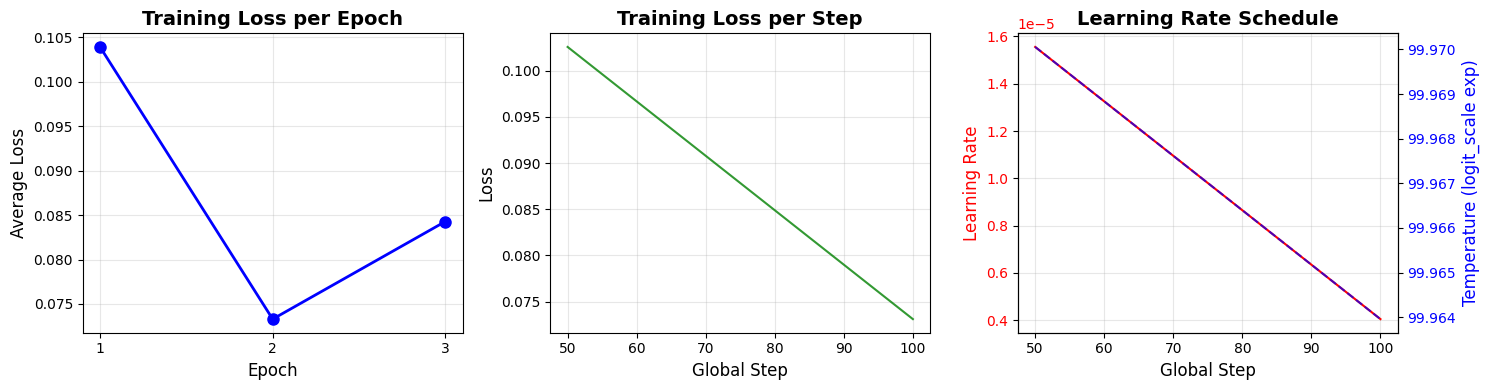


Training Summary
  Total epochs: 3
  Total time: 682.18 seconds (11.37 minutes)
  Peak memory: 417.55 MB
  Initial loss: 0.1039
  Final loss: 0.0843
  Loss reduction: 18.9%


In [28]:
import matplotlib.pyplot as plt

def plot_training_curves(training_logs: Dict):
    """Plot training loss curves and learning rate schedule."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: Epoch-level loss
    epochs = [epoch["epoch"] for epoch in training_logs["epochs"]]
    losses = [epoch["avg_loss"] for epoch in training_logs["epochs"]]
    
    ax1 = axes[0]
    ax1.plot(epochs, losses, 'b-o', linewidth=2, markersize=8)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Average Loss", fontsize=12)
    ax1.set_title("Training Loss per Epoch", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(epochs)
    
    # Plot 2: Step-level loss (if available)
    ax2 = axes[1]
    if "step_logs" in training_logs and training_logs["step_logs"]:
        steps = [log["global_step"] for log in training_logs["step_logs"]]
        step_losses = [log["loss"] for log in training_logs["step_logs"]]
        ax2.plot(steps, step_losses, 'g-', linewidth=1.5, alpha=0.8)
        ax2.set_xlabel("Global Step", fontsize=12)
        ax2.set_ylabel("Loss", fontsize=12)
        ax2.set_title("Training Loss per Step", fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "Step-level logs\nnot available", ha='center', va='center', fontsize=12)
        ax2.set_title("Training Loss per Step", fontsize=14, fontweight='bold')
        ax2.axis('off')
    
    # Plot 3: Learning rate and temperature (if available)
    ax3 = axes[2]
    if "step_logs" in training_logs and training_logs["step_logs"]:
        steps = [log["global_step"] for log in training_logs["step_logs"]]
        lrs = [log["learning_rate"] for log in training_logs["step_logs"]]
        temps = [log.get("temperature", 100.0) for log in training_logs["step_logs"]]
        
        ax3.plot(steps, lrs, 'r-', linewidth=1.5, label="Learning Rate")
        ax3.set_xlabel("Global Step", fontsize=12)
        ax3.set_ylabel("Learning Rate", fontsize=12, color='r')
        ax3.tick_params(axis='y', labelcolor='r')
        ax3.set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # Add temperature on secondary y-axis
        ax3_twin = ax3.twinx()
        ax3_twin.plot(steps, temps, 'b--', linewidth=1.5, label="Temperature", alpha=0.7)
        ax3_twin.set_ylabel("Temperature (logit_scale exp)", fontsize=12, color='b')
        ax3_twin.tick_params(axis='y', labelcolor='b')
    else:
        ax3.text(0.5, 0.5, "Step-level logs\nnot available", ha='center', va='center', fontsize=12)
        ax3.set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
        ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("Training Summary")
    print("=" * 60)
    print(f"  Total epochs: {len(training_logs['epochs'])}")
    print(f"  Total time: {training_logs['total_time_seconds']:.2f} seconds ({training_logs['total_time_seconds']/60:.2f} minutes)")
    print(f"  Peak memory: {training_logs['peak_memory_mb']:.2f} MB")
    print(f"  Initial loss: {training_logs['epochs'][0]['avg_loss']:.4f}")
    print(f"  Final loss: {training_logs['epochs'][-1]['avg_loss']:.4f}")
    print(f"  Loss reduction: {(1 - training_logs['epochs'][-1]['avg_loss'] / training_logs['epochs'][0]['avg_loss']) * 100:.1f}%")

# Plot training curves
print("=" * 60)
print("Training Curve Visualization")
print("=" * 60)
plot_training_curves(training_logs)


## 10. Generate Embeddings for Evaluation


In [29]:
model.eval()

def generate_image_embeddings_from_keys(
    image_keys: List[str],
    model,
    processor,
    device: Union[str, torch.device],
    batch_size: int = 32,
) -> Tuple[np.ndarray, List[str]]:
    """Generate image embeddings for a list of unique image_keys."""
    model.eval()
    embeddings = []
    kept_keys = []
    failed_count = 0

    with torch.no_grad():
        for idx in tqdm(range(0, len(image_keys), batch_size), desc="Generating image embeddings"):
            batch_keys = image_keys[idx:idx+batch_size]
            batch_images = []
            batch_kept_keys = []

            for img_key in batch_keys:
                bucket, key = get_image_path_in_minio(img_key)
                img = load_image_from_minio(bucket, key)
                if img is not None:
                    batch_images.append(img)
                    batch_kept_keys.append(img_key)
                else:
                    failed_count += 1

            if len(batch_images) == 0:
                continue

            inputs = processor(images=batch_images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            image_embeds = model.get_image_features(**inputs)
            embeddings.append(image_embeds.cpu().numpy())
            kept_keys.extend(batch_kept_keys)

    if failed_count > 0:
        print(f"⚠ {failed_count} images failed to load")

    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(kept_keys)} unique image embeddings (shape: {embeddings.shape})")
    return embeddings, kept_keys


def generate_text_embeddings(
    texts: List[str], 
    model, 
    processor, 
    device: Union[str, torch.device], 
    batch_size: int = 32
) -> np.ndarray:
    """Generate text embeddings for all captions."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for idx in tqdm(range(0, len(texts), batch_size), desc="Generating text embeddings"):
            batch_texts = texts[idx:idx+batch_size]
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            text_embeds = model.get_text_features(**inputs)
            embeddings.append(text_embeds.cpu().numpy())
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(texts)} text embeddings (shape: {embeddings.shape})")
    return embeddings


print("=" * 60)
print("Generating Embeddings for Evaluation")
print("=" * 60)

start_time = time.time()

# Image embeddings
unique_image_keys = test_df["image_key"].dropna().astype(str).unique().tolist()
image_embeddings, image_keys = generate_image_embeddings_from_keys(
    unique_image_keys, model, processor, main_device, batch_size=16
)

# Text embeddings
unique_captions = test_df["caption"].unique().tolist()
text_embeddings = generate_text_embeddings(unique_captions, model, processor, main_device, batch_size=16)
unique_captions_list = list(unique_captions)

embedding_time = time.time() - start_time

# Create mapping dictionaries
image_key_to_idx = {key: idx for idx, key in enumerate(image_keys)}
caption_to_idx = {caption: idx for idx, caption in enumerate(unique_captions_list)}

# Precompute lookup dictionaries
print("\nPrecomputing lookup dictionaries...")

recipe_to_image_indices: Dict[str, List[int]] = {}
for recipe_id in test_df["recipe_id"].unique():
    recipe_id_str = str(recipe_id)
    recipe_images = test_df.loc[test_df["recipe_id"] == recipe_id, "image_key"].dropna().astype(str).unique()
    recipe_to_image_indices[recipe_id_str] = [
        image_key_to_idx.get(img_key) for img_key in recipe_images if image_key_to_idx.get(img_key) is not None
    ]

recipe_to_caption_indices: Dict[str, List[int]] = {}
recipe_to_caption_text: Dict[str, str] = {}
recipe_to_all_caption_indices: Dict[str, List[int]] = {}
for recipe_id in test_df["recipe_id"].unique():
    recipe_id_str = str(recipe_id)
    recipe_captions = test_df[test_df["recipe_id"] == recipe_id]["caption"].unique()
    if len(recipe_captions) == 0:
        continue
    representative_caption = max(recipe_captions, key=lambda c: (len(c), c))
    cap_idx = caption_to_idx.get(representative_caption)
    if cap_idx is not None:
        recipe_to_caption_indices[recipe_id_str] = [cap_idx]
        recipe_to_caption_text[recipe_id_str] = representative_caption
    all_caption_indices = [caption_to_idx.get(caption) for caption in recipe_captions if caption_to_idx.get(caption) is not None]
    recipe_to_all_caption_indices[recipe_id_str] = sorted(set(all_caption_indices))

image_key_to_recipe_id: Dict[str, str] = {}
for _, row in test_df.iterrows():
    image_key_to_recipe_id[str(row["image_key"])] = str(row["recipe_id"])
    
print(f"✓ Embedding generation complete in {embedding_time:.2f} seconds")


Generating Embeddings for Evaluation


Generating image embeddings: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


✓ Generated 97 unique image embeddings (shape: (97, 512))


Generating text embeddings: 100%|██████████| 4/4 [00:00<00:00, 14.76it/s]


✓ Generated 54 text embeddings (shape: (54, 512))

Precomputing lookup dictionaries...
✓ Embedding generation complete in 2.42 seconds


## 11. Evaluation (Same Protocol as Baseline and LoRA)


In [30]:
def compute_recall_at_k(scores: np.ndarray, ground_truth_indices: List[int], k: int) -> float:
    """Compute Recall@K."""
    if len(ground_truth_indices) == 0:
        return 0.0
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_set = set(top_k_indices)
    for gt_idx in ground_truth_indices:
        if gt_idx in top_k_set:
            return 1.0
    return 0.0

def compute_mrr(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """Compute Mean Reciprocal Rank."""
    if len(ground_truth_indices) == 0:
        return 0.0
    sorted_indices = np.argsort(scores)[::-1]
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return 1.0 / rank
    return 0.0

def compute_first_hit_rank(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """Compute rank of first correct result."""
    if len(ground_truth_indices) == 0:
        return float(len(scores) + 1)
    sorted_indices = np.argsort(scores)[::-1]
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return float(rank)
    return float(len(scores) + 1)

def evaluate_text_to_image_by_recipe(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_indices: Dict[str, List[int]],
    recipe_to_image_indices: Dict[str, List[int]],
    k_values: List[int],
    should_compute_mrr: bool = True,
    should_compute_median_rank: bool = True
) -> Dict:
    """Evaluate Text → Image retrieval by recipe_id."""
    print("\nEvaluating Text → Image retrieval (by recipe_id)...")
    unique_recipe_ids = test_df["recipe_id"].unique()
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    median_ranks = [] if should_compute_median_rank else None
    
    for recipe_id in tqdm(unique_recipe_ids, desc="Processing recipes"):
        recipe_id_str = str(recipe_id)
        caption_indices = recipe_to_caption_indices.get(recipe_id_str, [])
        if not caption_indices:
            continue
        text_idx = caption_indices[0]
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        ground_truth_indices = [idx for idx in recipe_to_image_indices.get(recipe_id_str, []) if idx is not None]
        if len(ground_truth_indices) == 0:
            continue
        for k in k_values:
            recalls[f"R@{k}"].append(compute_recall_at_k(similarities, ground_truth_indices, k))
        if should_compute_mrr:
            mrr_scores.append(compute_mrr(similarities, ground_truth_indices))
        if should_compute_median_rank:
            median_ranks.append(compute_first_hit_rank(similarities, ground_truth_indices))
    
    results = {f"R@{k}": float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0 for k in k_values}
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    if should_compute_median_rank and median_ranks:
        results["MedianRank_first_hit"] = float(np.median(median_ranks))
        results["MeanRank_first_hit"] = float(np.mean(median_ranks))
    return results

def evaluate_image_to_text_by_recipe(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    k_values: List[int],
    should_compute_mrr: bool = True,
    should_compute_median_rank: bool = True
) -> Dict:
    """Evaluate Image → Text retrieval by recipe_id."""
    print("\nEvaluating Image → Text retrieval (by recipe_id)...")
    unique_images = test_df["image_key"].dropna().astype(str).unique()
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    median_ranks = [] if should_compute_median_rank else None
    
    for img_key in tqdm(unique_images, desc="Processing images"):
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        if not recipe_id_str:
            continue
        ground_truth_indices = [idx for idx in recipe_to_all_caption_indices.get(recipe_id_str, []) if idx is not None]
        if len(ground_truth_indices) == 0:
            continue
        for k in k_values:
            recalls[f"R@{k}"].append(compute_recall_at_k(similarities, ground_truth_indices, k))
        if should_compute_mrr:
            mrr_scores.append(compute_mrr(similarities, ground_truth_indices))
        if should_compute_median_rank:
            median_ranks.append(compute_first_hit_rank(similarities, ground_truth_indices))
    
    results = {f"R@{k}": float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0 for k in k_values}
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    if should_compute_median_rank and median_ranks:
        results["MedianRank_first_hit"] = float(np.median(median_ranks))
        results["MeanRank_first_hit"] = float(np.mean(median_ranks))
    return results

def l2_normalize_np(x: np.ndarray, axis: int = -1, eps: float = 1e-12) -> np.ndarray:
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / np.maximum(norm, eps)

# Normalize embeddings
NORMALIZE_FOR_EVAL = True
image_embeddings_eval = l2_normalize_np(image_embeddings) if NORMALIZE_FOR_EVAL else image_embeddings
text_embeddings_eval = l2_normalize_np(text_embeddings) if NORMALIZE_FOR_EVAL else text_embeddings

# Run evaluation
print("=" * 60)
print("Evaluation (Same Protocol as Baseline and LoRA)")
print("=" * 60)

text_to_image_results = evaluate_text_to_image_by_recipe(
    test_df, text_embeddings_eval, image_embeddings_eval,
    recipe_to_caption_indices, recipe_to_image_indices,
    K_VALUES, COMPUTE_MRR, COMPUTE_MEDIAN_RANK
)

image_to_text_results = evaluate_image_to_text_by_recipe(
    test_df, text_embeddings_eval, image_embeddings_eval,
    recipe_to_all_caption_indices, image_key_to_idx, image_key_to_recipe_id,
    K_VALUES, COMPUTE_MRR, COMPUTE_MEDIAN_RANK
)

# Display results
print("\n" + "=" * 60)
print("Evaluation Results")
print("=" * 60)
print("\nText → Image Retrieval:")
for metric, value in text_to_image_results.items():
    print(f"  {metric}: {value:.4f}")

print("\nImage → Text Retrieval:")
for metric, value in image_to_text_results.items():
    print(f"  {metric}: {value:.4f}")


Evaluation (Same Protocol as Baseline and LoRA)

Evaluating Text → Image retrieval (by recipe_id)...


Processing recipes: 100%|██████████| 54/54 [00:00<00:00, 3074.84it/s]



Evaluating Image → Text retrieval (by recipe_id)...


Processing images: 100%|██████████| 97/97 [00:00<00:00, 5870.82it/s]


Evaluation Results

Text → Image Retrieval:
  R@1: 0.6481
  R@5: 0.9074
  R@10: 0.9444
  MRR: 0.7609
  MedianRank_first_hit: 1.0000
  MeanRank_first_hit: 3.2222

Image → Text Retrieval:
  R@1: 0.7216
  R@5: 0.9381
  R@10: 0.9381
  MRR: 0.8107
  MedianRank_first_hit: 1.0000
  MeanRank_first_hit: 2.5567


## 12. Visualize Retrieval Results

Visual inspection of retrieval results helps understand model behavior beyond aggregate metrics.


In [31]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Use random seed from config
RANDOM_SEED = CONFIG["reproducibility"]["random_seed"]

def visualize_text_to_image_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_text: Dict[str, str],
    recipe_to_image_indices: Dict[str, List[int]],
    caption_to_idx: Dict[str, int],
    image_keys: List[str],
    image_key_to_recipe_id: Dict[str, str],
    n_examples: int = 3
):
    """Visualize Text → Image retrieval: for each recipe, show top-5 images."""
    unique_recipe_ids = test_df["recipe_id"].unique()
    sample_recipe_ids = pd.Series(unique_recipe_ids).sample(
        min(n_examples, len(unique_recipe_ids)),
        random_state=RANDOM_SEED
    )
    
    for recipe_idx, recipe_id in enumerate(sample_recipe_ids):
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        gt_image_indices = set(recipe_to_image_indices.get(recipe_id_str, []))
        
        fig = plt.figure(figsize=(16, 5))
        gs = gridspec.GridSpec(1, 6, width_ratios=[2, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        ax0 = fig.add_subplot(gs[0])
        ax0.text(0.5, 0.5, f'Query:\n"{caption}"', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax0.axis('off')
        
        for i, img_idx in enumerate(top5_indices):
            img_key = image_keys[img_idx]
            bucket, key = get_image_path_in_minio(img_key)
            img = load_image_from_minio(bucket, key)
            if img is None:
                continue
            is_correct = img_idx in gt_image_indices
            similarity_score = similarities[img_idx]
            # Get caption for this image (via recipe_id)
            img_recipe_id = image_key_to_recipe_id.get(img_key)
            img_caption = recipe_to_caption_text.get(img_recipe_id, "Unknown") if img_recipe_id else "Unknown"
            # Truncate caption if too long
            if len(img_caption) > 30:
                img_caption = img_caption[:27] + "..."
            ax = fig.add_subplot(gs[i + 1])
            ax.imshow(img)
            ax.axis('off')
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(border_width)
            # Show caption and score
            ax.set_title(f"Rank {i+1}\n{'✓' if is_correct else '✗'}\n\"{img_caption}\"\nScore: {similarity_score:.3f}", fontsize=8, fontweight='bold')
        plt.tight_layout()
        plt.show()

def visualize_image_to_text_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    unique_captions: List[str],
    recipe_to_caption_text: Dict[str, str],
    n_examples: int = 3
):
    """Visualize Image → Text retrieval: for each image, show top-5 captions."""
    unique_images = test_df["image_key"].dropna().astype(str).unique()
    sample_images = pd.Series(unique_images).sample(
        min(n_examples, len(unique_images)),
        random_state=RANDOM_SEED
    )
    
    for img_idx, img_key in enumerate(sample_images):
        img_emb_idx = image_key_to_idx.get(img_key)
        if img_emb_idx is None:
            continue
        img_emb = image_embeddings[img_emb_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        gt_caption_indices = set(recipe_to_all_caption_indices.get(recipe_id_str, []))
        
        bucket, key = get_image_path_in_minio(img_key)
        query_img = load_image_from_minio(bucket, key)
        if query_img is None:
            continue
        
        fig = plt.figure(figsize=(16, 4))
        gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.3, bottom=0.15)
        
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(query_img)
        ax0.axis('off')
        # Show caption for query image (via recipe_id)
        query_caption = recipe_to_caption_text.get(recipe_id_str, "Unknown") if recipe_id_str else "Unknown"
        if len(query_caption) > 30:
            query_caption = query_caption[:27] + "..."
        ax0.set_title(f'Query Image\n"{query_caption}"', fontsize=11, fontweight='bold')
        
        if recipe_id_str:
            recipe_caption = recipe_to_caption_text.get(recipe_id_str, "Unknown")
            display_recipe = recipe_caption if len(recipe_caption) <= 40 else recipe_caption[:37] + "..."
            ax0.text(0.5, -0.15, f'Recipe: {recipe_id_str}\n"{display_recipe}"',
                   ha='center', va='top', fontsize=9,
                   transform=ax0.transAxes,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   wrap=True)
        
        for i, text_idx in enumerate(top5_indices):
            caption = unique_captions[text_idx]
            is_correct = text_idx in gt_caption_indices
            similarity_score = similarities[text_idx]
            ax = fig.add_subplot(gs[i + 1])
            ax.text(0.5, 0.5, f'Rank {i+1}\n{"✓" if is_correct else "✗"}\nScore: {similarity_score:.3f}\n\n"{caption}"',
                   ha='center', va='center', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='lightgreen' if is_correct else 'lightcoral', alpha=0.7),
                   wrap=True)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

print("✓ Visualization functions defined")


✓ Visualization functions defined



📝 Text → Image Retrieval (Top-5 images for each recipe):


/tmp/ipykernel_44208/648374368.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


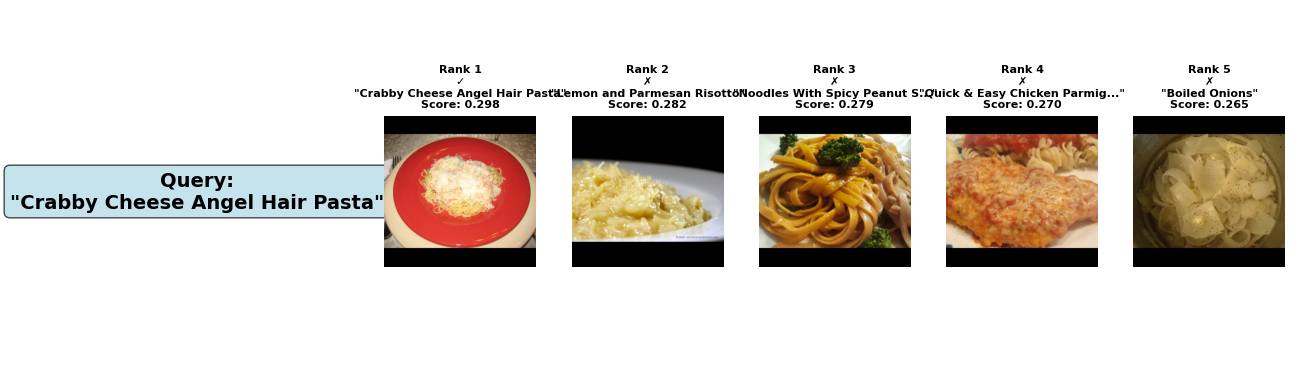

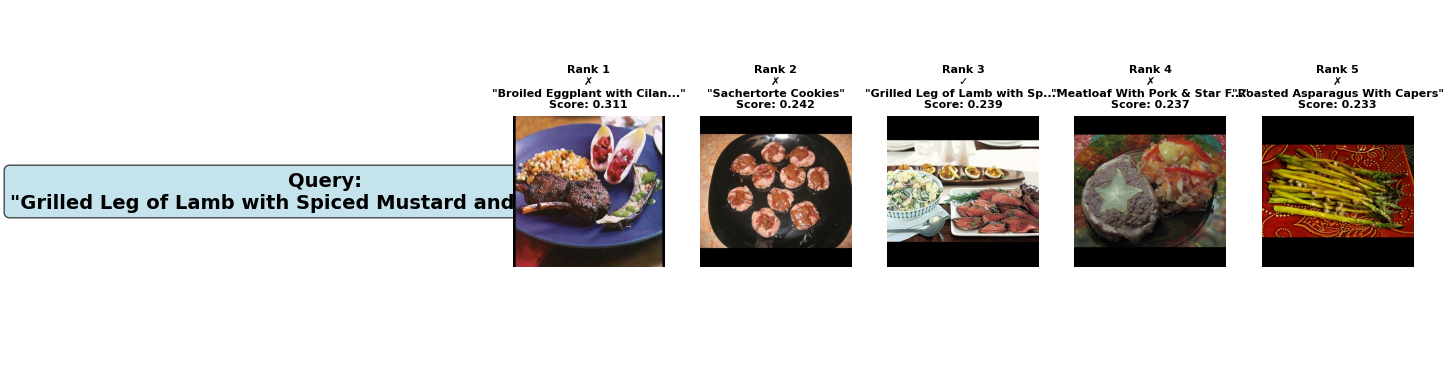

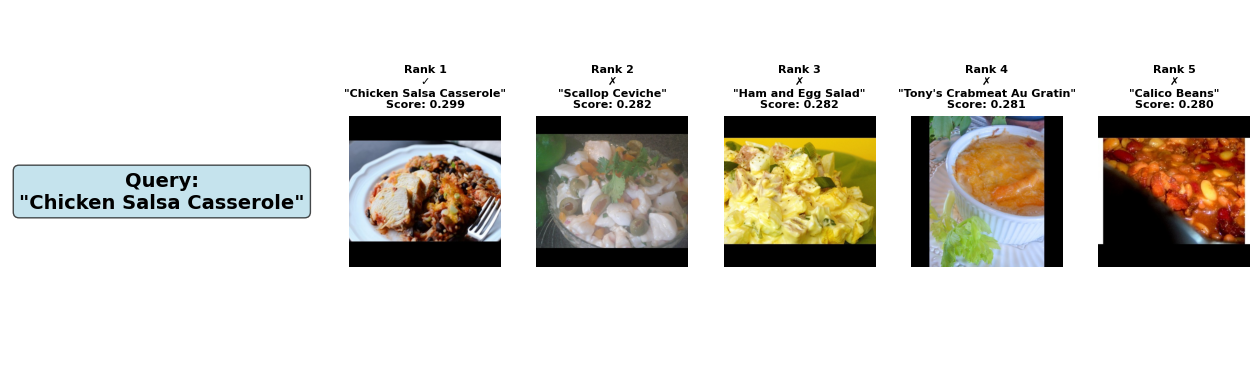


🖼️ Image → Text Retrieval (Top-5 captions for each image):


/tmp/ipykernel_44208/648374368.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


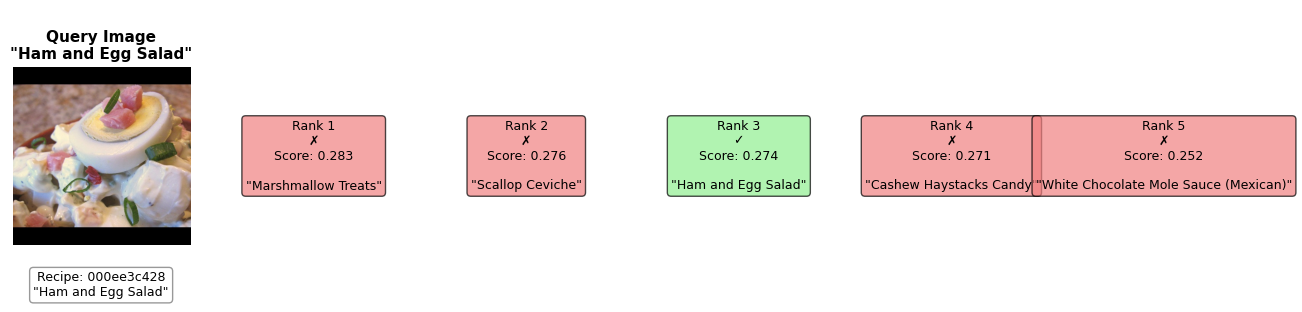

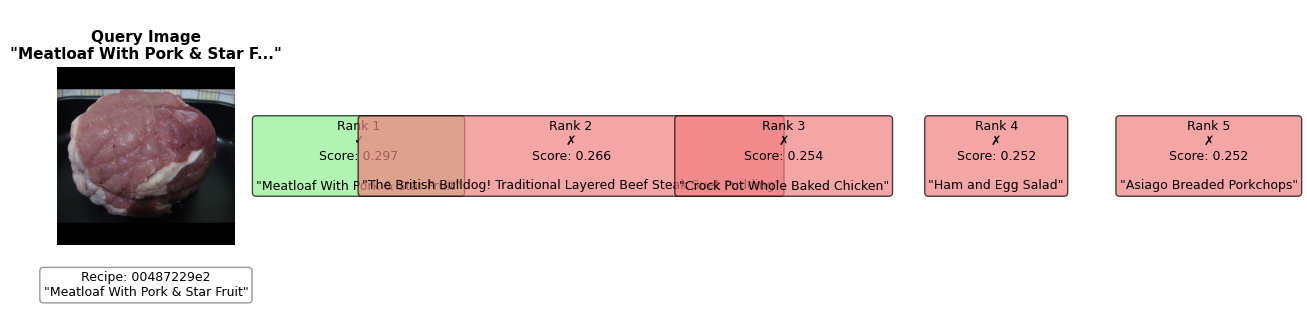

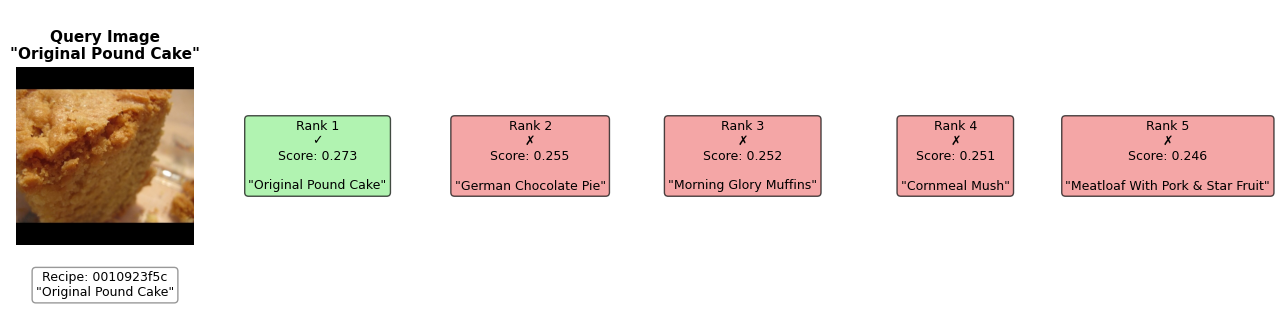

In [32]:
# Verify required variables exist (safety check)
assert "image_key_to_recipe_id" in globals(), "image_key_to_recipe_id not found. Run evaluation section first."
assert "text_embeddings_eval" in globals(), "text_embeddings_eval not found. Run evaluation section first."
assert "image_embeddings_eval" in globals(), "image_embeddings_eval not found. Run evaluation section first."
assert "unique_captions_list" in globals(), "unique_captions_list not found. Run evaluation section first."
assert "image_keys" in globals(), "image_keys not found. Run evaluation section first."

print("\n📝 Text → Image Retrieval (Top-5 images for each recipe):")
visualize_text_to_image_retrieval(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_caption_text,
    recipe_to_image_indices,
    caption_to_idx,
    image_keys,
    image_key_to_recipe_id,
    n_examples=3
)

print("\n🖼️ Image → Text Retrieval (Top-5 captions for each image):")
visualize_image_to_text_retrieval(
    test_df,
    text_embeddings_eval,
    image_embeddings_eval,
    recipe_to_all_caption_indices,
    image_key_to_idx,
    image_key_to_recipe_id,
    unique_captions_list,
    recipe_to_caption_text,
    n_examples=3
)


## 13. Generate Qualitative Examples


In [33]:
N_QUALITATIVE_EXAMPLES = CONFIG["evaluation"]["n_examples"]
RANDOM_SEED = CONFIG["reproducibility"]["random_seed"]

def generate_top5_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_caption_text: Dict[str, str],
    recipe_to_image_indices: Dict[str, List[int]],
    caption_to_idx: Dict[str, int],
    image_keys: List[str],
    image_key_to_recipe_id: Dict[str, str],
    n_examples: int = 5
) -> List[Dict]:
    """Generate qualitative examples for text→image retrieval."""
    examples = []
    valid_recipe_ids = []
    for recipe_id in test_df["recipe_id"].unique():
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        if not caption:
            continue
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        gt_image_indices = recipe_to_image_indices.get(recipe_id_str, [])
        if len(gt_image_indices) > 0:
            valid_recipe_ids.append(recipe_id)
    
    if len(valid_recipe_ids) == 0:
        return examples
    
    sample_recipe_ids = pd.Series(valid_recipe_ids).sample(
        min(n_examples, len(valid_recipe_ids)), random_state=RANDOM_SEED
    )
    
    for recipe_id in sample_recipe_ids:
        recipe_id_str = str(recipe_id)
        caption = recipe_to_caption_text.get(recipe_id_str)
        text_idx = caption_to_idx.get(caption)
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        gt_image_indices = set(recipe_to_image_indices.get(recipe_id_str, []))
        
        top5_images = []
        for i, idx in enumerate(top5_indices):
            img_key = image_keys[idx]
            img_recipe_id = image_key_to_recipe_id.get(img_key)
            top5_images.append({
                "rank": i + 1,
                "image_key": img_key,
                "recipe_id": img_recipe_id,
                "similarity": float(similarities[idx]),
                "is_correct": idx in gt_image_indices
            })
        
        examples.append({
            "query_type": "text_to_image",
            "recipe_id": recipe_id_str,
            "query_caption": caption,
            "top5_images": top5_images
        })
    
    return examples

def generate_image_to_text_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    recipe_to_all_caption_indices: Dict[str, List[int]],
    image_key_to_idx: Dict[str, int],
    image_key_to_recipe_id: Dict[str, str],
    unique_captions: List[str],
    n_examples: int = 5
) -> List[Dict]:
    """Generate qualitative examples for image→text retrieval."""
    examples = []
    unique_images = test_df["image_key"].dropna().astype(str).unique()
    sample_images = pd.Series(unique_images).sample(
        min(n_examples, len(unique_images)), random_state=RANDOM_SEED
    )
    
    for img_key in sample_images:
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        recipe_id_str = image_key_to_recipe_id.get(img_key)
        gt_caption_indices = set(recipe_to_all_caption_indices.get(recipe_id_str, []))
        
        top5_captions = []
        for i, text_idx in enumerate(top5_indices):
            top5_captions.append({
                "rank": i + 1,
                "caption": unique_captions[text_idx],
                "similarity": float(similarities[text_idx]),
                "is_correct": text_idx in gt_caption_indices
            })
        
        examples.append({
            "query_type": "image_to_text",
            "recipe_id": recipe_id_str,
            "query_image_key": img_key,
            "top5_captions": top5_captions
        })
    
    return examples

# Generate examples
text_to_image_examples = generate_top5_examples(
    test_df, text_embeddings_eval, image_embeddings_eval,
    recipe_to_caption_text, recipe_to_image_indices, caption_to_idx,
    image_keys, image_key_to_recipe_id, n_examples=N_QUALITATIVE_EXAMPLES
)

image_to_text_examples = generate_image_to_text_examples(
    test_df, text_embeddings_eval, image_embeddings_eval,
    recipe_to_all_caption_indices, image_key_to_idx, image_key_to_recipe_id,
    unique_captions_list, n_examples=N_QUALITATIVE_EXAMPLES
)

all_examples = text_to_image_examples + image_to_text_examples
print(f"✓ Generated {len(all_examples)} qualitative examples")


✓ Generated 10 qualitative examples


## 14. Save Results


In [34]:
# Prepare results
results = {
    "run_id": RUN_ID,
    "timestamp": datetime.now(timezone.utc).isoformat().replace("+00:00", "Z"),
    "model": MODEL_NAME,
    "method": "qlora",
    "quantization": {
        "enabled": True,
        "type": BNB_4BIT_QUANT_TYPE,
        "double_quant": BNB_4BIT_USE_DOUBLE_QUANT,
    },
    "metrics": {
        "text_to_image": text_to_image_results,
        "image_to_text": image_to_text_results,
    },
    "metadata": {
        "device": DEVICE,
        "embedding_time_seconds": float(embedding_time),
    },
    "model_info": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "trainable_ratio": float(trainable_params / total_params),
    },
    "training_info": {
        "total_time_seconds": training_logs["total_time_seconds"],
        "peak_memory_mb": training_logs["peak_memory_mb"],
        "total_steps": training_logs["total_steps"],
        "num_epochs": TRAINING_CONFIG["num_epochs"],
        "final_loss": float(training_logs["epochs"][-1]["avg_loss"]) if training_logs["epochs"] else None,
    },
}

# Save results
print(f"Saving results to {RESULTS_KEY}...")
save_json_to_minio(results, FINE_TUNING_BUCKET, RESULTS_KEY)

# Save qualitative examples
print(f"Saving qualitative examples to {EXAMPLES_KEY}...")
save_json_to_minio({"examples": all_examples}, FINE_TUNING_BUCKET, EXAMPLES_KEY)

print("\n" + "=" * 60)
print("✓ All results saved successfully")
print("=" * 60)
print(f"Model: {MODEL_NAME} (QLoRA fine-tuned)")
print(f"Run ID: {RUN_ID}")
print(f"\nResults saved to:")
print(f"  - {RESULTS_KEY}")
print(f"  - {EXAMPLES_KEY}")
print(f"  - {LOGS_KEY}")
print(f"  - {CONFIG_KEY}")
print(f"  - {ADAPTERS_DIR}/")


Saving results to experiments/qlora/run_qlora_20260108_201025/results_qlora.json...
Saving qualitative examples to experiments/qlora/run_qlora_20260108_201025/examples_top5.json...

✓ All results saved successfully
Model: openai/clip-vit-base-patch32 (QLoRA fine-tuned)
Run ID: qlora_20260108_201025

Results saved to:
  - experiments/qlora/run_qlora_20260108_201025/results_qlora.json
  - experiments/qlora/run_qlora_20260108_201025/examples_top5.json
  - experiments/qlora/run_qlora_20260108_201025/training_logs.json
  - experiments/qlora/run_qlora_20260108_201025/config.yaml
  - experiments/qlora/run_qlora_20260108_201025/adapters/


## 15. Summary and Comparison

This section provides a summary of QLoRA results and compares them with baseline (M0) and LoRA (M1) if available.


In [35]:
# Try to load baseline and LoRA results for comparison
def load_json_from_minio(bucket: str, key: str) -> Optional[Dict]:
    """Load JSON from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        return json.loads(obj["Body"].read().decode("utf-8"))
    except Exception:
        return None

# Load baseline results
baseline_results = load_json_from_minio(FINE_TUNING_BUCKET, "experiments/baseline/results_baseline.json")

# Load LoRA results (try to find the latest run)
lora_results = None
try:
    response = s3.list_objects_v2(Bucket=FINE_TUNING_BUCKET, Prefix="experiments/lora/")
    if "Contents" in response:
        lora_runs = [obj["Key"] for obj in response["Contents"] if "results_lora.json" in obj["Key"]]
        if lora_runs:
            # Get the most recent
            lora_runs.sort(reverse=True)
            lora_results = load_json_from_minio(FINE_TUNING_BUCKET, lora_runs[0])
except Exception:
    pass

print("=" * 80)
print("EXPERIMENT COMPARISON: M0 (Baseline) vs M1 (LoRA) vs M2 (QLoRA)")
print("=" * 80)

# Build comparison table
comparison_data = []

# QLoRA results (current)
comparison_data.append({
    "Model": "M2: QLoRA",
    "Quantization": "4-bit NF4 (bitsandbytes)",
    "Trainable Params": f"{trainable_params:,}",
    "T→I R@1": text_to_image_results.get("R@1", 0),
    "T→I R@5": text_to_image_results.get("R@5", 0),
    "T→I MRR": text_to_image_results.get("MRR", 0),
    "I→T R@1": image_to_text_results.get("R@1", 0),
    "I→T R@5": image_to_text_results.get("R@5", 0),
    "I→T MRR": image_to_text_results.get("MRR", 0),
    "Training Time": f"{training_logs['total_time_seconds']:.1f}s",
    "Peak VRAM": f"{training_logs['peak_memory_mb']:.1f} MB" if training_logs['peak_memory_mb'] > 0 else "N/A",
})

# LoRA results
if lora_results and "metrics" in lora_results:
    lora_t2i = lora_results["metrics"].get("text_to_image", {})
    lora_i2t = lora_results["metrics"].get("image_to_text", {})
    lora_training = lora_results.get("training_info", {})
    comparison_data.append({
        "Model": "M1: LoRA",
        "Quantization": "None (FP32)",
        "Trainable Params": f"{lora_results.get('model_info', {}).get('trainable_parameters', 'N/A'):,}",
        "T→I R@1": lora_t2i.get("R@1", 0),
        "T→I R@5": lora_t2i.get("R@5", 0),
        "T→I MRR": lora_t2i.get("MRR", 0),
        "I→T R@1": lora_i2t.get("R@1", 0),
        "I→T R@5": lora_i2t.get("R@5", 0),
        "I→T MRR": lora_i2t.get("MRR", 0),
        "Training Time": f"{lora_training.get('total_time_seconds', 0):.1f}s",
        "Peak VRAM": f"{lora_training.get('peak_memory_mb', 0):.1f} MB" if lora_training.get('peak_memory_mb', 0) > 0 else "N/A",
    })

# Baseline results
if baseline_results and "metrics" in baseline_results:
    baseline_t2i = baseline_results["metrics"].get("text_to_image", {})
    baseline_i2t = baseline_results["metrics"].get("image_to_text", {})
    comparison_data.append({
        "Model": "M0: Baseline",
        "Quantization": "None (FP32)",
        "Trainable Params": "0 (frozen)",
        "T→I R@1": baseline_t2i.get("R@1", 0),
        "T→I R@5": baseline_t2i.get("R@5", 0),
        "T→I MRR": baseline_t2i.get("MRR", 0),
        "I→T R@1": baseline_i2t.get("R@1", 0),
        "I→T R@5": baseline_i2t.get("R@5", 0),
        "I→T MRR": baseline_i2t.get("MRR", 0),
        "Training Time": "N/A",
        "Peak VRAM": "N/A",
    })

# Display comparison
comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Retrieval Performance Comparison:")
print("-" * 80)
display(comparison_df)

# Print summary
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"""
Hypothesis H2: QLoRA achieves comparable performance to LoRA with reduced memory

QLoRA Results (M2):
  - Text→Image R@1: {text_to_image_results.get('R@1', 0):.4f}
  - Text→Image R@5: {text_to_image_results.get('R@5', 0):.4f}
  - Image→Text R@1: {image_to_text_results.get('R@1', 0):.4f}
  - Image→Text R@5: {image_to_text_results.get('R@5', 0):.4f}
  - Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)
  - Quantization: {'4-bit NF4 (bitsandbytes)'}
  - Training time: {training_logs['total_time_seconds']:.1f} seconds

Expected Benefits of QLoRA (when run with CUDA):
  - ~4x reduction in model memory footprint
  - Comparable retrieval performance to LoRA
  - Enables fine-tuning on consumer GPUs (e.g., 8GB VRAM)
""")

print("""
✓ QLoRA completed successfully with 4-bit NF4 quantization!
  - Model weights quantized to 4-bit using bitsandbytes
  - ~4x memory savings compared to FP32
  - LoRA adapters trained in full precision
""")


EXPERIMENT COMPARISON: M0 (Baseline) vs M1 (LoRA) vs M2 (QLoRA)

📊 Retrieval Performance Comparison:
--------------------------------------------------------------------------------


,Model,Quantization,Trainable Params,T→I R@1,T→I R@5,T→I MRR,I→T R@1,I→T R@5,I→T MRR,Training Time,Peak VRAM
0,M2: QLoRA,4-bit NF4 (bitsandbytes),"983,041",0.648148,0.907407,0.760935,0.721649,0.938144,0.810711,682.2s,417.6 MB
1,M0: Baseline,None (FP32),0 (frozen),0.666667,0.907407,0.775861,0.731959,0.927835,0.827224,N/A,N/A



KEY FINDINGS

Hypothesis H2: QLoRA achieves comparable performance to LoRA with reduced memory

QLoRA Results (M2):
  - Text→Image R@1: 0.6481
  - Text→Image R@5: 0.9074
  - Image→Text R@1: 0.7216
  - Image→Text R@5: 0.9381
  - Trainable parameters: 983,041 (1.08%)
  - Quantization: 4-bit NF4 (bitsandbytes)
  - Training time: 682.2 seconds

Expected Benefits of QLoRA (when run with CUDA):
  - ~4x reduction in model memory footprint
  - Comparable retrieval performance to LoRA
  - Enables fine-tuning on consumer GPUs (e.g., 8GB VRAM)


✓ QLoRA completed successfully with 4-bit NF4 quantization!
  - Model weights quantized to 4-bit using bitsandbytes
  - ~4x memory savings compared to FP32
  - LoRA adapters trained in full precision



In [36]:
# Notebook complete!
print("=" * 60)
print("QLoRA Fine-Tuning Complete!")
print("=" * 60)
print(f"Device: CUDA")
print(f"Quantization: bitsandbytes 4-bit NF4")
print(f"Run ID: {RUN_ID}")


QLoRA Fine-Tuning Complete!
Device: CUDA
Quantization: bitsandbytes 4-bit NF4
Run ID: qlora_20260108_201025
